# Introduction

[Lido-Anchor integration](https://medium.com/anchor-protocol/anchor-protocol-lido-partner-to-launch-beth-704c1d96cd60) allows stETH holders to access to collateralized lending and Anchor liquidity mining rewards converting ETH or stETH to bETH. bETH tokens, being liquid, tokenized representations of bonded assets with their token value backed by ETH2 staking positions, exist on both Ethereum-side and Terra-side. Minted by submitting ETH or stETH to Ethereum-side bETH contracts, bETH tokens are simultaniuosly minted to the Terra-side where can be used as collateral to Anchor for borrowing UST on that collateral.

The most important indicator of a loan posision is its risk ratio representing the ratio of the liability and borrow limit. Since the borrow limit fluctuates with the oracle-reported bAsset price (either bETH or bLuna), loan positions with a risk ratio greater than one are subject to liquidation.

This notebook is aimed to analyze current Anchor loan positions backed by bETH by their riskiness in order to assess the current state of 'bad' collaterals and probability of bETH liquidations might happen due to price fluctuation

The notebook is split into following sections:
<ol>
  <li>Introduction on how Risk Rating Model works</li>
  <li>Overview of loan positions distribution</li> 
  <li>Closer look at loan positions sensivity to price changes and scenario modelling</li>      
</ol>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import beth
pd.options.display.float_format = '{:,.2f}'.format


# 1. Risk Rating Model

For the purpose of this analysis, we downloaded information on all loans from [Anchor Market](https://finder.terra.money/columbus-5/address/terra1sepfj7s0aeg5967uxnfk4thzlerrsktkpelm5s) smart contract and information on all collaterals from [Anchor Overseer](https://finder.terra.money/columbus-5/address/terra1tmnqgvg567ypvsvk6rwsga3srp7e3lg6u0elp8) smart contract. After that, we merge 2 tables on borrower id and delete addresses that don't use bETH as collateral. 

In [2]:
# Use this fuction to get current state of bETH collateral (~ 8-10 min)
beth.load_data_csv('anchor_data.csv')

,borrower,bETHcollateral,percent,ust_loan,bLunacollateral
9550,terra12tgau944796dqx4luundj9entckt5d4u07fvy5,"3,801,458,619.00",0.04,6670957262010,0.00
20159,terra14ntpk7vlgx9svhpzrlskj7ddexr3q85vxatvqy,"3,300,072,545.00",0.08,5363502687950,0.00
8541,terra1fghts93trvnhkyt6r0pv6q9gq5dlkpx48j75z9,"2,666,000,000.00",0.11,4820072611459,0.00
22560,terra1cr72gl930e5lahh8v36glhvw3gfyzl9wrn48c9,"2,411,463,460.00",0.14,6900838324610,"96,480,130,344.00"
1451,terra1pssqdpvzhy6x27vh2xkscwmkxxxsk3l3yvdqn7,"2,241,826,240.00",0.17,6719839738843,"120,338,941,117.00"
...,...,...,...,...,...
9465,terra12g29209u9fsfhk7tumx3pr37j467h0y5mr98qd,1.00,1.00,652,0.00
25498,terra1mg49vkhrhrmtfd5lew0wzdwpv299lhru3p9jm2,1.00,1.00,565,0.00
19521,terra15a39gwx4szgs8k7etwwes0c9fg7psy7xmykfrr,1.00,1.00,510,0.00
20974,terra1kwxm9aghfztf72f2eegv6gttd8pjumyf3ksqrw,1.00,1.00,853,0.00


In [2]:
# Or use prepared data 
# The analysis below is done on 2021-10-08
data = beth.get_data_csv('anchor_data.csv')

Ancor [defines](https://docs.anchorprotocol.com/protocol/loan-liquidation) risk ratio as 'the liability to borrow limit ratio' 
$$risk\ ratio=\frac{liability}{borrow\ limit}$$
where the borrow limit [is calculated](https://docs.anchorprotocol.com/protocol/money-market) as 'the sum of locked collateral value, times the maximum LTV ratio of collateral'
$$borrow\ limit=\sum{amount\ locked\cdot{bAssetPrice}\cdot{maxLTV}}$$

As borrows can have multiple collaterals (bETH and bLuna), we calculated risk ratio based on current bETH and bLuna prices.

Currently, the maximum LTV ratio of collateral is set as [60%](https://twitter.com/anchor_protocol/status/1417239566692454412?s=09) meaning that liquidations start when the liability equals to 60% of weigthed average collateral amount. 

According to Ancor docs, loan positions with a risk ratio of [80%](https://docs.anchorprotocol.com/protocol/loan-liquidation) (= 48% of collateral) or below are considered safe from undercollateralization. Obviously, these two tiers (0-80, 80-100) are not sufficient to differentiate the quality of collaterals. For this reason, we introduced the scale for assessing bETH-collateral risks.

We departed from the debt coverage of collateral of 2.50x, 1.75x, 1.50x, 1.25x, 1.10x, 1.00x and devided the loans into 7 groups respectively.

We consider groups A and B+ as quite 'safe zone', while groups 'C','D','liquidation' (C+) as 'dangerous zone'.


In [3]:
collateral_loan_ratio = np.array([2.5, 1.75, 1.5, 1.25, 1.1, 1])
beth.get_scale(collateral_loan_ratio)

,collateral/loan ratio,risk ratio,risk rating
0,> - 2.50x,0 - 40%,A
1,2.50x - 1.75x,40% - 57%,B+
2,1.75x - 1.50x,57% - 67%,B
3,1.50x - 1.25x,67% - 80%,B-
4,1.25x - 1.10x,80% - 91%,C
5,1.10x - 1.00x,91% - 100%,D
6,=1.00x,>=100%,liquidation


In [4]:
beth_price = beth.get_beth_price()
bluna_price = beth.get_bluna_price()
data = beth.get_risks(data, beth_price, bluna_price, collateral_loan_ratio)
risk_distribution = beth.get_distr(data)
risk_distribution_amount = risk_distribution[['bETH']]
risk_distribution_count =  risk_distribution[['cnt']]
risk_distribution_prc =  risk_distribution[['percent']]
total_beth_amount = data.bETHcollateral.sum()
total_beth_count = data.bETHcollateral.count()
print(f"Total amount of bETH locked in Anchor: {total_beth_amount:,.0f} bETH")
print(f"Total number of bETH collaterals: {total_beth_count:,.0f}")
risk_distribution

Total amount of bETH locked in Anchor: 98,362 bETH
Total number of bETH collaterals: 3,387


,bETH,cnt,percent,average,median
risk_rating,,,,,
A,"3,885.12",439,3.95,8.85,1.01
B+,"15,830.45",1048,16.09,15.11,2.00
B,"32,314.80",753,32.85,42.91,3.00
B-,"21,734.55",815,22.10,26.67,3.17
C,"20,589.21",255,20.93,80.74,3.00
D,"3,558.38",62,3.62,57.39,4.45
liquidation,449.48,15,0.46,29.97,0.00


Given significant difference between median and average positions in nearly all risk rating group means uneven disribution of bETH collaterals and causes outliers that we will see below and that requires more focused monitoring of large bETH collaterals.


In [6]:
bad_collateral = ['C','D','liquidation']
good_collateral = ['A', 'B+']
bad_collateral_amount = risk_distribution.query('index in @bad_collateral').bETH.sum()
good_collateral_amount = risk_distribution.query('index in @good_collateral').bETH.sum()
print(f"Collaterals in 'safe zone': {good_collateral_amount/total_beth_amount:.0%} of all bETH-collaterals")
print(f"Collaterals in 'dangerous zone': {bad_collateral_amount/total_beth_amount:.0%} of all bETH-collaterals")

Collaterals in 'safe zone': 25% of all bETH-collaterals
Collaterals in 'dangerous zone': 18% of all bETH-collaterals


# 2. Loan Positions Distribution


Top-10 borrows sorted by bETH amount:

In [7]:
top_borrowers = data[['borrower','bETHcollateral','risk_ratio','ust_loan','risk_rating']].sort_values(by = 'bETHcollateral', ascending = False).head(10)
top_borrowers

,borrower,bETHcollateral,risk_ratio,ust_loan,risk_rating
0,terra1w77m4kkcqurq0ef36pyn5wlp9g2j3u4ruhypn5,"10,466.74",81.30,"17,423,913.08",C
1,terra1amxtnx9rj9xzuu4ypzrc7cy0haw778ez4043wa,"10,010.00",59.57,"12,131,137.70",B
2,terra12tgau944796dqx4luundj9entckt5d4u07fvy5,"4,018.28",59.86,"4,893,788.98",B
3,terra14ntpk7vlgx9svhpzrlskj7ddexr3q85vxatvqy,"3,300.07",61.31,"4,116,271.98",B
4,terra1pssqdpvzhy6x27vh2xkscwmkxxxsk3l3yvdqn7,"2,731.83",80.47,"7,968,556.89",C
5,terra1fghts93trvnhkyt6r0pv6q9gq5dlkpx48j75z9,"2,666.00",76.33,"4,139,775.84",B-
6,terra1s6zwj84kmec9x38gt4qarg2y05z2xcm3tk5w3p,"1,653.00",27.23,"5,911,170.80",A
7,terra1t8svw3du6w9r57l48fkne3fwwzsdhdtr5m0gle,"1,453.35",72.03,"2,129,607.96",B-
8,terra10s3znd04kew6adj050trx5z5z54ahytdaejr3j,"1,142.00",81.19,"3,532,595.18",C
9,terra15xgfhapl2e9xyg9qewzk49y35qvhqcwwrhnu3s,"1,129.00",75.55,"1,735,256.64",B-


In [8]:
top_borrowers_bad_amount = top_borrowers.query('risk_rating in @bad_collateral').bETHcollateral.sum()
top_borrowers_bad_count = top_borrowers.query('risk_rating in @bad_collateral').bETHcollateral.count()
top_borrowers_good_amount = top_borrowers.query('risk_rating in @good_collateral').bETHcollateral.sum()
top_borrowers_good_count = top_borrowers.query('risk_rating in @good_collateral').bETHcollateral.count()
print(f"bEth deposited in Ancor by Top-10 borrowers: {top_borrowers.bETHcollateral.sum():,.0f}, or {top_borrowers.bETHcollateral.sum()/total_beth_amount:.0%} of total amount")
if top_borrowers_good_amount>0:
    print("AB+ risk groups ('safe zone'):")
    print(f"\tThe number of borrowers: {top_borrowers_good_count}")
    print(f"\tThe amount of bETH-collateral: {top_borrowers_good_amount:,.0f} bETH")
if top_borrowers_bad_amount>0:
    print("C+ risk groups ('dangerous zone'):")
    print(f"\tThe number of borrowers: {top_borrowers_bad_count}")
    print(f"\tThe amount of bETH-collateral: {top_borrowers_bad_amount:,.0f} bETH")

bEth deposited in Ancor by Top-10 borrowers: 38,570, or 39% of total amount
AB+ risk groups ('safe zone'):
	The number of borrowers: 1
	The amount of bETH-collateral: 1,653 bETH
C+ risk groups ('dangerous zone'):
	The number of borrowers: 3
	The amount of bETH-collateral: 14,341 bETH


Top-10 riskiest positions:

In [9]:
top_riskiest = data[['borrower','bETHcollateral','risk_ratio','ust_loan','risk_rating']].sort_values(by = (['risk_ratio']), ascending = False).head(10)
top_riskiest

,borrower,bETHcollateral,risk_ratio,ust_loan,risk_rating
1087,terra1m3x9ldpjnvssug6y0nxdklsz8flnchr8rqh6ep,6.21,91.56,"24,579.39",D
2957,terra1yca9t5e8t3tvujcha386zh0ddhx5cv8dp0cc6z,0.22,91.30,598.51,D
11,terra1ratk9n5gtuqakqpfyuhm5uyyqhhkq0uvz5yvkv,973.42,88.25,"1,747,629.33",C
129,terra1cr8gvqj86duhgfpvjs5x237v4wfsf0qykacsjx,99.63,85.78,"2,846,181.99",C
884,terra1mvuvy4jr3zkxr5z5v0pef0l4q6uyheskvrzvcs,9.35,84.48,"16,065.33",C
1149,terra1ypap8u9z4vykp35lalw9ryl7pnruuxjj6agmut,5.73,84.48,"9,851.87",C
2728,terra1chc3n94rh5cygrmnf8af7h78qtx4zsgyhm0d97,0.48,84.18,817.83,C
62,terra1hqmrmwxt44qs7hr8queza29z8gmgt2d29f5nmh,208.69,84.03,"356,792.91",C
41,terra19a42jzwyvkpnctvws28lk48rj9aen5qnmn6gc3,340.00,83.85,"580,000.58",C
18,terra1dmjhj4gmsaxxvvxgjnaz9tddd3p35ksfca836f,738.09,83.83,"1,414,356.03",C


In [10]:
top_riskiest_amount = top_riskiest.bETHcollateral.sum()
print(f'Top-10 riskiest positions cover {top_riskiest_amount/total_beth_amount:.1%} ({top_riskiest_amount:,.0f} bETH) of all bETH-collateral and {top_riskiest_amount/bad_collateral_amount:.1%} of C+ risk groups.')

Top-10 riskiest positions cover 2.4% (2,382 bETH) of all bETH-collateral and 13.8% of C+ risk groups.


 The chart below represents the relationship between the risk ratio and bETH amount locked as a collateral. 

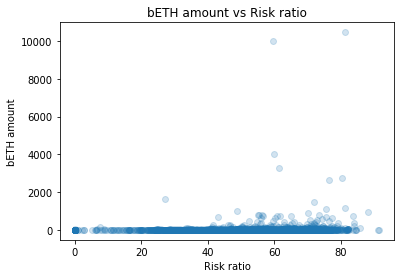

In [11]:
x = data['risk_ratio']
y = data['bETHcollateral']
plt.scatter(x, y, alpha=0.2)
plt.title("bETH amount vs Risk ratio")
plt.xlabel("Risk ratio")
plt.ylabel("bETH amount")
plt.show()

In [13]:
print(f'Loan positions with more than 1000 bETH in collateral: {len(data[data.bETHcollateral>1000]):,.0f}, or {len(data[data.bETHcollateral>1000])/total_beth_count:.1%} of total number ({data[data.bETHcollateral>1000].bETHcollateral.sum():,.0f} bETH, or {data[data.bETHcollateral>1000].bETHcollateral.sum()/total_beth_amount:,.0%})')
print(f'Loan positions with less than 10 bETH in collateral: {len(data[data.bETHcollateral<10]):,.0f}, or {len(data[data.bETHcollateral<10])/total_beth_count:.0%} of total number ({data[data.bETHcollateral<10].bETHcollateral.sum():,.0f} bETH, or {data[data.bETHcollateral<10].bETHcollateral.sum()/total_beth_amount:,.0%})')
print(f'Loan positions with less than 1 bETH in collateral: {len(data[data.bETHcollateral<1]):,.0f}, or {len(data[data.bETHcollateral<1])/total_beth_count:.0%} of total number')
print(f'{len(data[data.bETHcollateral>1000]):,.0f} borrowers form {data[data.bETHcollateral>1000].bETHcollateral.sum()/total_beth_amount:,.0%} of total bETH amount, while {len(data[data.bETHcollateral<10])/total_beth_count:.0%} of borrowers cover  {data[data.bETHcollateral<10].bETHcollateral.sum()/total_beth_amount:,.0%}')


Loan positions with more than 1000 bETH in collateral: 11, or 0.3% of total number (39,578 bETH, or 40%)
Loan positions with less than 10 bETH in collateral: 2,566, or 76% of total number (5,994 bETH, or 6%)
Loan positions with less than 1 bETH in collateral: 1,102, or 33% of total number


The relationship between the proportion of bETH in a collateral and risk ratio is shown below.

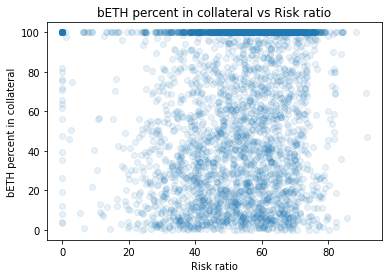

In [14]:
x = data['risk_ratio']
y = data['percent_bETH']
plt.scatter(x, y, alpha=0.1)
plt.title("bETH percent in collateral vs Risk ratio")
plt.xlabel("Risk ratio")
plt.ylabel("bETH percent in collateral")
plt.show()

In [15]:
print(f'Loan positions with more than 80% of bETH in collateral: {data[data.percent_bETH>=80].bETHcollateral.sum():,.0f} bETH, or {data[data.percent_bETH>=80].bETHcollateral.sum()/total_beth_amount:.0%} of total amount')
print(f'Number of loan positions with more than 80% of bETH in collateral: {data[data.percent_bETH>=80].bETHcollateral.count():,.0f}, or {data[data.percent_bETH>=80].bETHcollateral.count()/total_beth_count:.0%} of total collaterals')

Loan positions with more than 80% of bETH in collateral: 67,909 bETH, or 69% of total amount
Number of loan positions with more than 80% of bETH in collateral: 1,404, or 41% of total collaterals


# 3. Loan Positions Sensivity to Price Changes 

For loan positions sensivity analysis we should recompute the risk ratings due to price changes. 

We analysed historical data on bETH and bLuna prices since 2021-08-13 (when bETH was introduced) till 2021-09-30.  

In order to avoid 3d-graph modeling, we departed from the suggestion that bLuna and bETH prices are to some extent interconnected and we can reduce the prices combinations set by considering combined impact of both prices taken in their stable proportion. For this reason we needed to define the correspondence between changes in bETH price and the changes in bLuna price (the assets price change ratio) and the scale limits. For the former we used price volatility analysis, for the latter - combined impact analysis of the assets' price changes.

## 3.1 Price Changes Params

**Daily asset volatility** was calculated as hourly volatility of the asset over all given period (by computing percent change in the asset’s price over each hour within the given time horizon and determining the sample standard deviation over the set) scaled up to a daily volatility. 

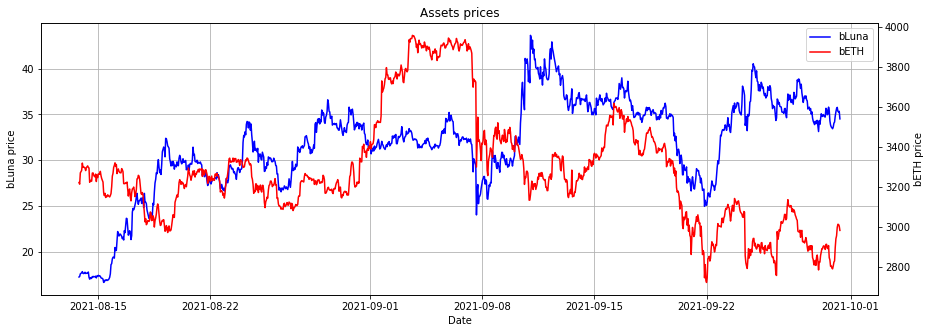

bLuna daily volatility: 10.3%
bETH daily volatility ratio: 4.8%


In [16]:
prices = beth.get_hourly_data()
prices = prices.pivot_table(index='hourly', values = ['bETH','bLuna'], aggfunc = ['first'])
prices.columns = ['bETH','bLuna']
prices['bLuna_ratio_n']=np.log(prices.bLuna/prices.bLuna.shift(-1).fillna(prices.bLuna))
prices['bETH_ratio_n']=np.log(prices.bETH/prices.bETH.shift(-1).fillna(prices.bETH))
vol_bLuna = prices['bLuna_ratio_n'].std()*24**0.5
vol_bETH = prices['bETH_ratio_n'].std()*24**0.5
fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(111)
lns1 = ax.plot(prices.index, prices['bLuna'], 'b', label = 'bLuna')
ax2 = ax.twinx()
lns2 = ax2.plot(prices.index, prices['bETH'], 'r', label = 'bETH')
ax.legend(lns1+lns2, [l.get_label() for l in lns1+lns2], loc=0)
ax.grid()
ax.set_title('Assets prices')
ax.set_xlabel("Date")
ax.set_ylabel("bLuna price")
ax2.set_ylabel("bETH price")
plt.show()
print(f'bLuna daily volatility: {vol_bLuna:.1%}')
print(f'bETH daily volatility ratio: {vol_bETH:.1%}')

For daily prices drops analysis we took daily ratio of open price (the first price of a day) and tne minimum one in that day.

Daily drops in bLuna and bETH prices revealed quite high correlation (we used Pearson's correlation).

Pearsons correlation: 0.700


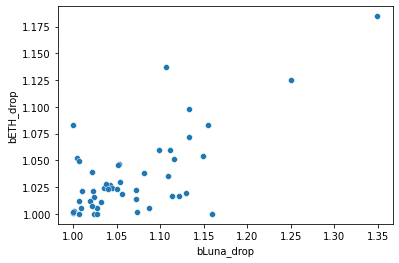

In [17]:
prices = beth.get_daily_data()
prices = prices.pivot_table(index='date', values = ['bETH','bLuna'], aggfunc = ['first', 'min','max','last'])
prices.columns = ['bETH_open','bLuna_open','bETH_min','bLuna_min','bETH_max','bLuna_max','bETH_close','bLuna_close']
prices = prices[['bETH_open','bLuna_open','bETH_min','bLuna_min']]
prices['bETH_drop'] = prices.bETH_open/prices.bETH_min
prices['bLuna_drop'] = prices.bLuna_open/prices.bLuna_min
beth.get_corr_analysis('bLuna_drop','bETH_drop', prices)

In order to determine **the scale limits** for price sensivity, we calculated combined impact as price drops production and sorted the data set in descending order of this impact.

In [18]:
prices['impact']=prices['bETH_drop']*prices['bLuna_drop']
prices.sort_values(by = 'impact', ascending = False).head(10)

,bETH_open,bLuna_open,bETH_min,bLuna_min,bETH_drop,bLuna_drop,impact
date,,,,,,,
2021-09-07,"3,909.25",32.40,"3,300.12",24.01,1.18,1.35,1.60
2021-09-20,"3,294.71",32.94,"2,927.37",26.36,1.13,1.25,1.41
2021-09-24,"3,131.39",36.22,"2,754.49",32.73,1.14,1.11,1.26
2021-09-13,"3,355.43",39.25,"3,097.63",33.97,1.08,1.16,1.25
2021-09-21,"2,950.55",27.20,"2,686.59",24.00,1.10,1.13,1.24
2021-09-26,"2,923.73",37.90,"2,727.74",33.46,1.07,1.13,1.21
2021-08-26,"3,222.68",29.99,"3,057.49",26.10,1.05,1.15,1.21
2021-09-08,"3,415.44",27.78,"3,223.49",25.00,1.06,1.11,1.18
2021-09-28,"2,927.89",36.86,"2,785.75",33.02,1.05,1.12,1.17


Correlation in assets prices' drops let us use the ratio of daily volatility for scale building purpose: it means that each 1% decrease in bETH price is highly probable followed by ~2.14% drops in bLuna price.

The scale limits are taken as 18% for bETH price changes and 38.5% for bLuna price.

## 3.2 Loan Positions Sensivity Analysis


We calculated how would change the bETH amount and number of bETH collaterals in each group of risk rating model as well as bETH distribution if bETH and bLuna prices went down simultaneously in proportion 1% : 2.14%

In [19]:
max_change_bETH = 18 # max price change for bETH
step_bETH = 1 # scale step for bETH
coef_dependence = vol_bLuna/vol_bETH # scale step for bLuna

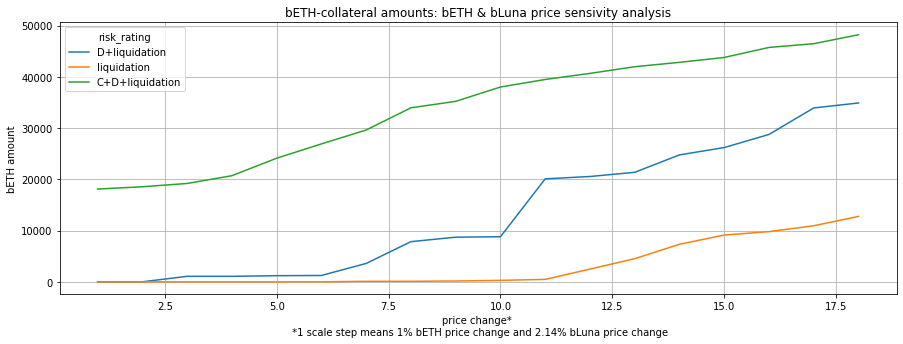

In [20]:
amount_price_sensivity = beth.get_change_price_interval(data, risk_distribution, max_change_bETH, step_bETH, coef_dependence, collateral_loan_ratio)[0]
pl = beth.plot_cde(amount_price_sensivity) 
plt.title("bETH-collateral amounts: bETH & bLuna price sensivity analysis")
plt.xlabel(f"price change* \n *1 scale step means 1% bETH price change and {round(coef_dependence,2)}% bLuna price change")
plt.ylabel("bETH amount")
pl.grid()
plt.show()

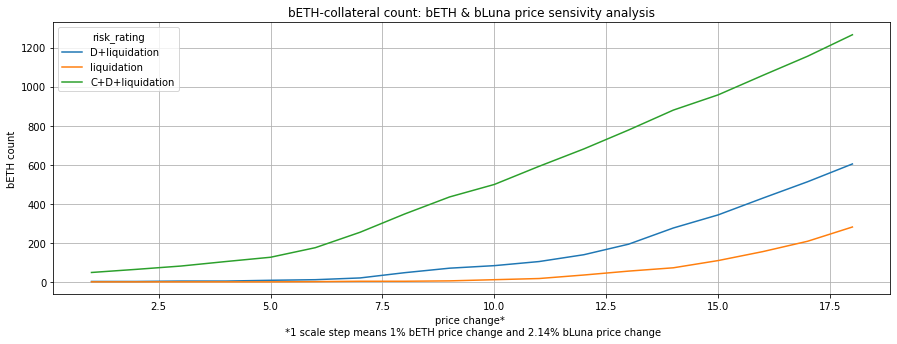

In [21]:
count_price_sensivity = beth.get_change_price_interval(data, risk_distribution, max_change_bETH, step_bETH, coef_dependence, collateral_loan_ratio)[1]
pl = beth.plot_cde(count_price_sensivity) 
plt.title("bETH-collateral count: bETH & bLuna price sensivity analysis")
plt.xlabel(f"price change* \n *1 scale step means 1% bETH price change and {round(coef_dependence,2)}% bLuna price change")
plt.ylabel("bETH count")
pl.grid()
plt.show()

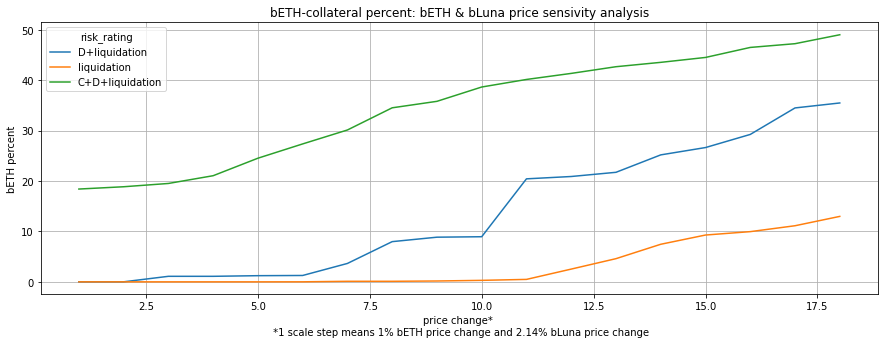

In [22]:
bETH_percent_price_sensivity = beth.get_change_price_interval(data, risk_distribution, max_change_bETH, step_bETH, coef_dependence, collateral_loan_ratio)[2]
pl = beth.plot_cde(bETH_percent_price_sensivity) 
plt.title("bETH-collateral percent: bETH & bLuna price sensivity analysis")
plt.xlabel(f"price change* \n *1 scale step means 1% bETH price change and {round(coef_dependence,2)}% bLuna price change")
plt.ylabel("bETH percent")
pl.grid()
plt.show()

Analysing the charts, we defined 3 scenarios.

**Probable future scenario**
<ol>
With daily volatility of bETH and bLuna prices as 4.8% and 10.3% respectively, we can expect slightly decrease in the safety of bETH collaterals being shifting to 'dangerous zone' collaterals with relatively small amounts of bETH: while the number of collaterals in 'dagerous zone' would more than quadrupled, the amount increase would not exceed 25% (currently 17.5%). The group 'liquidation' would remain empty.
</ol> 

**Medium risk scenario**
<ol>
The first significant shift in risk rating structure happens at decreasing bETH price by 10% and bLuna price by 21.4%: the amount at risk (D+liquidation) would be doubled and reach ~20k bETH. While the liquidations would be still not in the place, the overall amount of collateral in 'dangerous zone' would be quite high (~38k bETH, or 39%).
</ol>

**Catastrophic scenario** 
<ol>
This scenario implies decreasing bETH price by 17% and bLuna price by 36% that would push ~ 50% of all bETH collaterals in 'dangerous zone' and cause ~ 11k bETH liquidation. 
</ol>

# Conclusion

At the current states, the bETH collateral risk ratings are quite sate. Given current dynamic of both assets prices, it will require significant price drops to move the risk rating structure to its dangerous state and cause vast liquidations.

Looking at trends, 'Probable future scenario' illustrates daily changes in collateral risk ratings and should be considered as a given.

Seems to be a reasonable practice to introduce a monitoring procedure for large bETH collaterals and this notebook can be used for this purpose.
